# Day_085

### 練習時間
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras import optimizers
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理
def preproc_x(x, flatten = True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes = 10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation
def build_mlp(input_shape, output_units = 10, num_neurons=[512, 256, 128]):
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units = n_units, 
                      activation = "relu", 
                      name = "hidden_layer" + str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = Dense(units = n_units, 
                      activation = "relu", 
                      name = "hidden_layer" + str(i+1))(x)
            x = BatchNormalization()(x)
    
    output = Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = Model(inputs = [input_layer], outputs = [output])
    return model

In [6]:
def plt_model_result(result):
    color_bar = ["r", "g", "b", "y", "m", "k"]
    
    plt.figure(figsize=(16, 9))
    for i, cond in enumerate(result.keys()):
        plt.plot(range(len(result[cond]['train-loss'])), result[cond]['train-loss'], '-', label = 'train-' + cond, color = color_bar[i])
        plt.plot(range(len(result[cond]['valid-loss'])), result[cond]['valid-loss'], '--', label = 'valid-' + cond, color = color_bar[i])
    plt.title("Loss")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    plt.figure(figsize=(16, 9))
    for i, cond in enumerate(result.keys()):
        plt.plot(range(len(result[cond]['train-acc'])),result[cond]['train-acc'], '-', label = 'train-' + cond, color = color_bar[i])
        plt.plot(range(len(result[cond]['valid-acc'])),result[cond]['valid-acc'], '--', label = 'valid-' + cond, color = color_bar[i])
    plt.title("Accuracy")
    plt.legend(loc='center left', bbox_to_anchor = (1, 0.5))
    plt.show()

In [7]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

### 改變 monitor "Validation Accuracy"

In [8]:
# 載入 Callbacks
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = "val_acc", patience = 5, verbose = 1)

In [9]:
results = {}
for callbacks in ['0', '1']:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(input_shape = x_train.shape[1:])
    model.summary()
    optimizer = optimizers.SGD(lr = LEARNING_RATE, nesterov = True, momentum = MOMENTUM)
    model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)

    if callbacks == '0':
         model.fit(x_train, y_train, 
              epochs = EPOCHS, 
              batch_size = BATCH_SIZE, 
              validation_data = (x_test, y_test), 
              shuffle = True
             )
    else:
        model.fit(x_train, y_train, 
              epochs = EPOCHS, 
              batch_size = BATCH_SIZE, 
              validation_data = (x_test, y_test), 
              shuffle = True,
              callbacks=[earlystop]
             )
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = f'earlystop : {callbacks}'
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 33s 652us/step - loss: 0.5171 - acc: 0.8519 - val_loss: 1.6733 - val_acc: 0.4902
Epoch 50/50
50000/50000 [==============================] - 32s 644us/step - loss: 0.5007 - acc: 0.8593 - val_loss: 1.7110 - val_acc: 0.4797
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
______

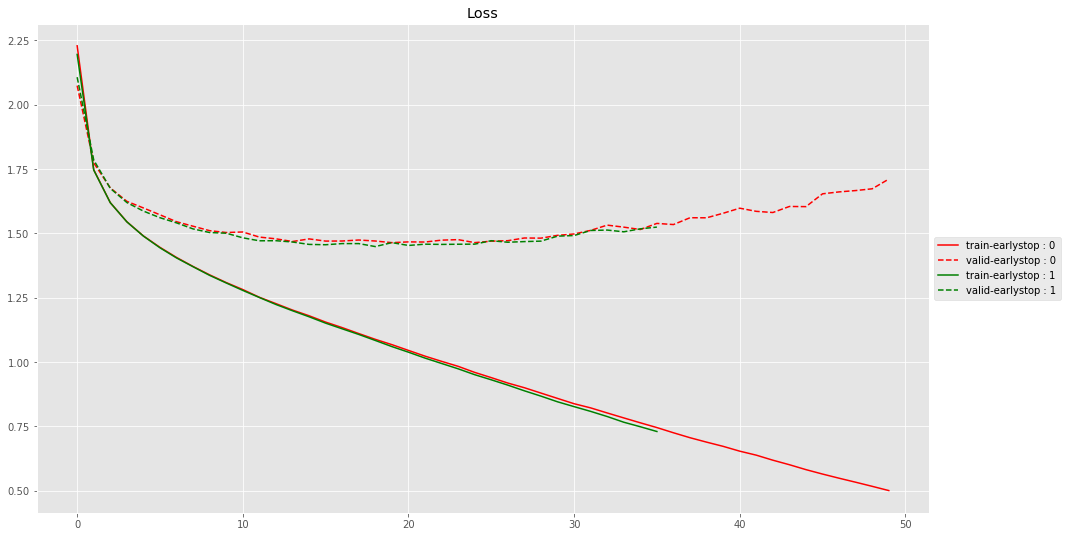

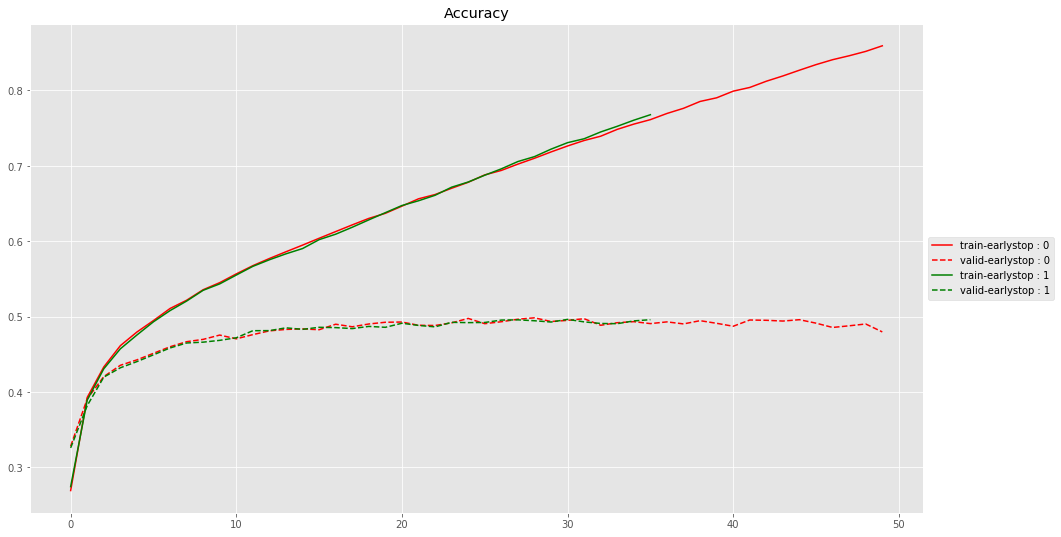

In [10]:
plt_model_result(results)

### 調整 earlystop 的等待次數至 10, 25 並比較結果

In [11]:
waittimes = [10, 25]
results = {}
for waittime in waittimes:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(input_shape = x_train.shape[1:])
    model.summary()
    optimizer = optimizers.SGD(lr = LEARNING_RATE, nesterov = True, momentum = MOMENTUM)
    model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)
    earlystop = EarlyStopping(monitor = "val_acc", patience = waittime, verbose = 1)
   
    model.fit(x_train, y_train, 
              epochs = EPOCHS, 
              batch_size = BATCH_SIZE, 
              validation_data = (x_test, y_test), 
              shuffle = True,
              callbacks=[earlystop]
             )
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = f'waittime : {waittime}'
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

Epoch 5/50
50000/50000 [==============================] - 27s 547us/step - loss: 1.4888 - acc: 0.4806 - val_loss: 1.5983 - val_acc: 0.4394
Epoch 6/50
50000/50000 [==============================] - 27s 549us/step - loss: 1.4416 - acc: 0.4974 - val_loss: 1.5526 - val_acc: 0.4531
Epoch 7/50
50000/50000 [==============================] - 27s 538us/step - loss: 1.4046 - acc: 0.5101 - val_loss: 1.5519 - val_acc: 0.4564
Epoch 8/50
50000/50000 [==============================] - 27s 544us/step - loss: 1.3681 - acc: 0.5243 - val_loss: 1.5375 - val_acc: 0.4626
Epoch 9/50
50000/50000 [==============================] - 27s 542us/step - loss: 1.3355 - acc: 0.5366 - val_loss: 1.5059 - val_acc: 0.4749
Epoch 10/50
50000/50000 [==============================] - 27s 546us/step - loss: 1.3047 - acc: 0.5479 - val_loss: 1.4865 - val_acc: 0.4783
Epoch 11/50
50000/50000 [==============================] - 27s 540us/step - loss: 1.2756 - acc: 0.5576 - val_loss: 1.4742 - val_acc: 0.4859
Epoch 12/50
50000/50000 [

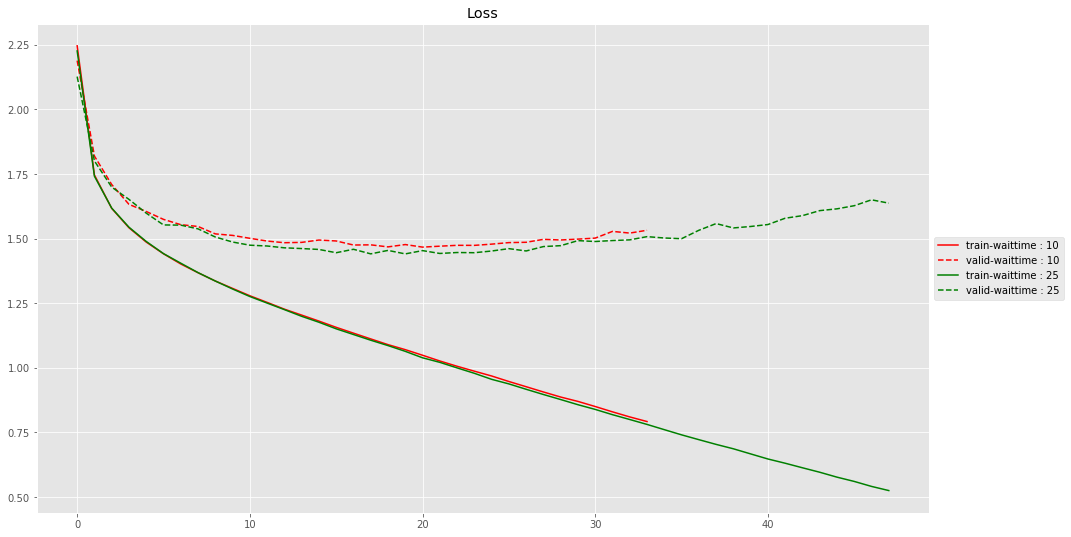

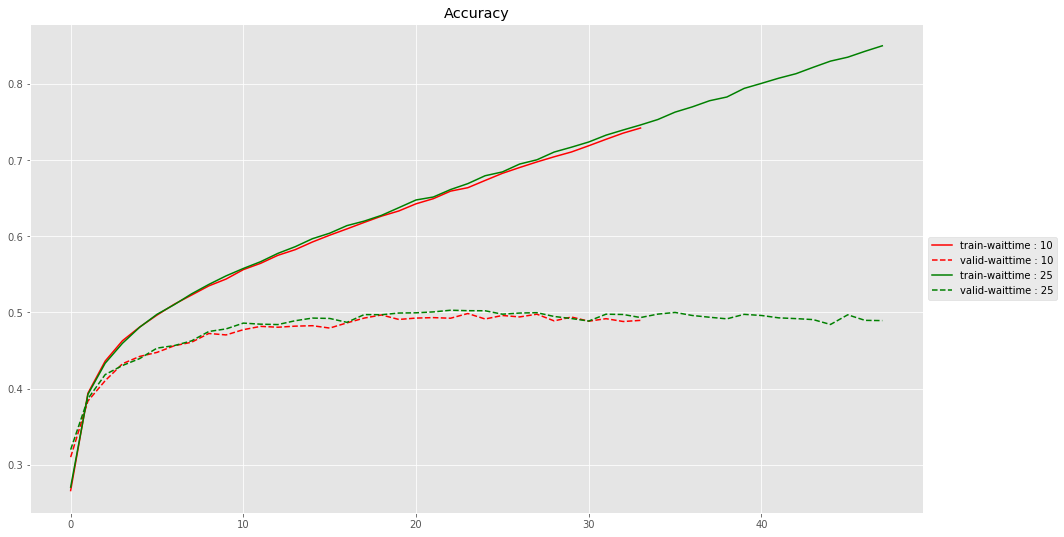

In [12]:
plt_model_result(results)